# Настройка


---
**Содержание:**


> Протокол оценки качества

>> Применение дополнительной информации из данных

>>> Baseline модель для дополнительных данных (Модель Ensemble + OneVsRestClassifier)

>>>> Модель для положительных вариантов

>>>>> Анализ данных

>>>> Модель для отрицательных вариантов

>>>>> Анализ данных

>>>> Результат

> Методы для построения векторных представлений

>> Подготовка тренировочных и тестовых данных

>> Тренировочные и тестовые данные

>> Baseline модель KNN

>>> Подготовка данных

>>> Обучение модели KNN

>>> Экспериментальная часть

>>>> Подготовка строки данных

>>>> Предсказание

>> Сложная модель item2vec

>>> Обучение модели по гиперпараметрам

>> Экспериментальная часть

>>> Тренировочные и тестовые данные

>>> Обучение модели по гиперпараметрам

> Оценка модели

>> Статистическая оценка

>> Результативная оценка
---

**Примечание:** 

Данные. 30Music Dataset.

Часть 1. Подготовка данных. Конвертация idomaar. 

Часть 2. Recomdendation Artist. 

In [9]:
!unzip /content/data_set.zip

Archive:  /content/data_set.zip
  inflating: id_recomended.csv       
  inflating: __MACOSX/._id_recomended.csv  
  inflating: persons.csv             
  inflating: __MACOSX/._persons.csv  
  inflating: artist_user.csv         
  inflating: __MACOSX/._artist_user.csv  
  inflating: users.csv               
  inflating: __MACOSX/._users.csv    
  inflating: id_non_recomended.csv   
  inflating: __MACOSX/._id_non_recomended.csv  


In [10]:
!unzip /content/item2vec_advance_rating_size300.zip

Archive:  /content/item2vec_advance_rating_size300.zip
   creating: item2vec_advance_rating_size300/
  inflating: item2vec_advance_rating_size300/item2vec_202006_3.wv.vectors.npy  
  inflating: __MACOSX/item2vec_advance_rating_size300/._item2vec_202006_3.wv.vectors.npy  
  inflating: item2vec_advance_rating_size300/item2vec_202006_3  
  inflating: __MACOSX/item2vec_advance_rating_size300/._item2vec_202006_3  
  inflating: item2vec_advance_rating_size300/item2vec_202006_3.trainables.syn1neg.npy  
  inflating: __MACOSX/item2vec_advance_rating_size300/._item2vec_202006_3.trainables.syn1neg.npy  


In [1]:
#Проверим подключение gpu
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
#Проверим тип процессора
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [2]:
#Колличество оперативки
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        10259968 kB
MemAvailable:   12392944 kB
Buffers:           71536 kB
Cached:          2172192 kB
SwapCached:            0 kB
Active:           810116 kB
Inactive:        1988312 kB
Active(anon):     490096 kB
Inactive(anon):      312 kB
Active(file):     320020 kB
Inactive(file):  1988000 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              5468 kB
Writeback:             0 kB
AnonPages:        554712 kB
Mapped:           339632 kB
Shmem:               904 kB
Slab:             168028 kB
SReclaimable:     131708 kB
SUnreclaim:        36320 kB
KernelStack:        3520 kB
PageTables:         6324 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2709004 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [3]:
#Для работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast, urllib
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
#Вaseline модели дополнительных данных
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.datasets import make_classification

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [5]:
!pip install joblib

In [6]:
#KNN модели
import joblib
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [7]:
#item2vec модели
import warnings
import gensim
import random
from gensim.models import Word2Vec
import datetime

# Протокол оценки качества

**Основная задача** - векторизовать музыкальных исполнителей, чтобы похожие авторы оказались ближе к другу в векторном пространстве, чем непохожие. 

Оценить реализованные модели, можно *количеством пересечений*, результатов по схожему запросу – результативный для решения задачи **Artist Recommendation** и преобладанию жанра большинства исполнителей. Жанр сравнивается, через данные об исполнителях из интернета.

Статически оценим модели, при помощи *recall, precision, f1 score*.

В классификации информации точность (*recall*) — это доля релевантных экземпляров среди найденных экземпляров, в то время как чувствительность (*precision*) — это доля общего количества соответствующих экземпляров. которые были фактически восстановлены. Поэтому точность и чувствительность основаны на понимании и степени релевантности.

![alt text](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

Предположим, что наш алгоритм Artist Recommendation идентифицирует 8 авторов как ближайшее похожие, содержащей 12 похожих авторов и несколько не похожих. Из 8 идентифицированных как похожие 5 фактически являются похожими (истинные положительные результаты), в то время как остальные являются не похожими (ложные положительные результаты). Точность программы составляет 5/8, а ее чувствительность - 5/12. Когда рекомендательная система возвращает 30 рекомендаций, только 20 из которых были релевантными, но не возвращает 40 дополнительных релевантных рекомендаций, ее точность равна 20/30 = 2/3, а ее чувствительность - 20/60 = 1/3. Таким образом, в данном случае точность - это «насколько полезны результаты поиска», а чувствительность - «насколько полны результаты».

*Оценка F1* — это среднее точности и чувствительности, где оценка F1 достигает своего лучшего значения в 1 (идеальная точность и чувствительность). 
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/3607c634303f2fd8b69ca4f9d97a491c45083cc5)


## Применение дополнительной информации из датасета.

In [ ]:
#import users data
users = pd.read_csv('/content/users.csv')
#drop column lastfm_username
users = users.dropna().drop('lastfm_username', axis = 1)
#age values from string to int
users['age'] = users['age'].astype(int)
#delete gender n - none
users = users[users['gender'] != '"n"']

gender
"f"    AxesSubplot(0.125,0.125;0.775x0.755)
"m"    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

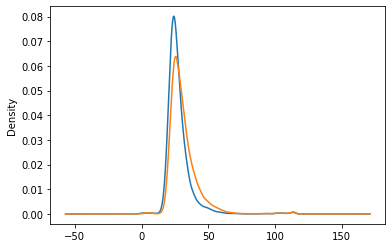

In [ ]:
#visualization gender - age
users.groupby('gender').age.plot(kind='kde')

In [ ]:
print("female median " + str(users[(users['gender'] == '"f"')]['age'].median()),",male median " + str(users[(users['gender'] == '"m"')]['age'].median()))

female median 26.0 ,male median 29.0


In [ ]:
#people from countries
pd.get_dummies(users[['country']]).sum().sort_values(ascending=False)

country_"US"    6909
country_"UK"    3046
country_"DE"    2788
country_"BR"    2151
country_"RU"    1995
                ... 
country_"DJ"       1
country_"ST"       1
country_"TF"       1
country_"TG"       1
country_"RW"       1
Length: 193, dtype: int64

In [ ]:
#transfer gender to value
users.loc[users['gender']=='"f"','gender'] = 1
users.loc[users['gender']=='"m"','gender'] = 0

In [ ]:
#transfer subscribertype to value
users.loc[users['subscribertype'] == '"base"', 'subscribertype'] = 1
users.loc[users['subscribertype'] == '"premium"', 'subscribertype'] = 0

In [ ]:
#maybe drop country values or change to value
users = pd.get_dummies(users).drop('gender_0',axis = 1).rename(columns = {'gender_1':'gender'}).drop('subscribertype_0',axis = 1).rename(columns = {'subscribertype_1':'subscribertype'})
len(users)

31031

In [ ]:
users.head()

,age,playcount,playlists,ID,gender,"country_""AD""","country_""AE""","country_""AF""","country_""AL""","country_""AM""","country_""AN""","country_""AO""","country_""AQ""","country_""AR""","country_""AT""","country_""AU""","country_""AW""","country_""AZ""","country_""BA""","country_""BB""","country_""BD""","country_""BE""","country_""BF""","country_""BG""","country_""BH""","country_""BI""","country_""BM""","country_""BN""","country_""BO""","country_""BR""","country_""BS""","country_""BT""","country_""BV""","country_""BY""","country_""CA""","country_""CC""","country_""CD""","country_""CG""","country_""CH""","country_""CI""",...,"country_""SC""","country_""SE""","country_""SG""","country_""SH""","country_""SI""","country_""SJ""","country_""SK""","country_""SL""","country_""SN""","country_""ST""","country_""SV""","country_""SY""","country_""SZ""","country_""TF""","country_""TG""","country_""TH""","country_""TK""","country_""TN""","country_""TR""","country_""TT""","country_""TV""","country_""TW""","country_""UA""","country_""UG""","country_""UK""","country_""UM""","country_""US""","country_""UY""","country_""UZ""","country_""VA""","country_""VE""","country_""VG""","country_""VI""","country_""VN""","country_""VU""","country_""WF""","country_""YE""","country_""ZA""","country_""ZW""",subscribertype
0,24,221012,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,39,217535,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,32,168054,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,23,45700,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,48,3869,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
!unzip /content/authors_p_n.zip

Archive:  /content/authors_p_n.zip
  inflating: id_recomended.csv       
  inflating: __MACOSX/._id_recomended.csv  
  inflating: id_non_recomended.csv   
  inflating: __MACOSX/._id_non_recomended.csv  


In [ ]:
#import artist set full
authors_positive = pd.read_csv('/content/id_recomended.csv')
authors_negative = pd.read_csv('/content/id_non_recomended.csv')

In [ ]:
#combine information from users to artist 
users_positive = pd.merge(users,authors_positive, left_on='ID', right_on='User_ID')

In [ ]:
#split dublicate rows by User_ID and Author_ID
users_positive = users_positive.drop_duplicates(subset=['User_ID', 'Author_ID_Recommended'])

In [ ]:
#number rows
len(users_positive)

2904846

In [ ]:
#drop id
users_positive = users_positive.drop('ID', axis = 1)

In [ ]:
#result
users_positive.head()

,age,playcount,playlists,gender,"country_""AD""","country_""AE""","country_""AF""","country_""AL""","country_""AM""","country_""AN""","country_""AO""","country_""AQ""","country_""AR""","country_""AT""","country_""AU""","country_""AW""","country_""AZ""","country_""BA""","country_""BB""","country_""BD""","country_""BE""","country_""BF""","country_""BG""","country_""BH""","country_""BI""","country_""BM""","country_""BN""","country_""BO""","country_""BR""","country_""BS""","country_""BT""","country_""BV""","country_""BY""","country_""CA""","country_""CC""","country_""CD""","country_""CG""","country_""CH""","country_""CI""","country_""CK""",...,"country_""SG""","country_""SH""","country_""SI""","country_""SJ""","country_""SK""","country_""SL""","country_""SN""","country_""ST""","country_""SV""","country_""SY""","country_""SZ""","country_""TF""","country_""TG""","country_""TH""","country_""TK""","country_""TN""","country_""TR""","country_""TT""","country_""TV""","country_""TW""","country_""UA""","country_""UG""","country_""UK""","country_""UM""","country_""US""","country_""UY""","country_""UZ""","country_""VA""","country_""VE""","country_""VG""","country_""VI""","country_""VN""","country_""VU""","country_""WF""","country_""YE""","country_""ZA""","country_""ZW""",subscribertype,User_ID,Author_ID_Recommended
0,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,303270
2,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,448432
171,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,236243
348,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,11467
370,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,370733


Дополнительно выделим тестовый датасет



In [ ]:
#2904846*0.2=580969
#2904846-580969=2323877
#dataset for prediction
user_test_positive = users_positive[2323877:]

### Baseline модель для дополнительных данных

Оцениваем вероятности подписки для пользователей. **Логика:** Предсказываем значения по параметрам в каждой строке, соединяем вероятности предсказаний и тестовые данные, по которым были совершенны предсказания. 

В данном случае значения вероятностей, по строкам с повторяющимися пользователями складываются и делятся на количество, чтобы узнать среднее вероятности положительных предсказаний. В результате, получаем данные *Пользователь - Вывод*.

**Как может применяться:** Допустим, у нас есть пользователи с разным диапазоном вероятности, покупки подписки. Анализируя данные, можно предлагать большие скидки, при уменьшении вероятности покупки для увеличения количество покупателей подписки.


Для позитивных случаев

#### Модель Ансамблей для положительных вариантов

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(users_positive.drop(columns=['User_ID','subscribertype']),
                                                    users_positive['subscribertype'], test_size=0.2, random_state=54)

In [ ]:
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Обучаем модель:
ensemble = RandomForestClassifier(criterion='gini', min_samples_leaf=10, max_depth=20, n_estimators=10, random_state=54)
clf_forest = OneVsRestClassifier(ensemble).fit(X_train, y_train)

In [ ]:
y_pred = clf_forest.predict(X_test)

In [ ]:
#Выполняем оценку:
#from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  5391,  14283],
       [     0, 561296]])

In [ ]:
#result for index 0
clf_forest.predict_proba(user_test_positive.drop(columns=['User_ID','subscribertype']))[0]

array([0.00862972, 0.99137028])

##### Анализируем данные по модели Ансамбли для положительных вариантов

In [ ]:
data_positive = clf_forest.predict_proba(user_test_positive.drop(columns=['User_ID','subscribertype']))

In [ ]:
data_positive = pd.concat([pd.DataFrame(data_positive, columns=['base','premium']),user_test_positive.reset_index()], axis = 1)

In [ ]:
#found out mean group by one user id to check further values
data_positive[data_positive['User_ID'] == 37505]['base'].mean()

0.009300300481955206

In [ ]:
data_positive.drop(data_positive.columns.difference(['base','premium','User_ID']), 1, inplace=True)

In [ ]:
data_positive = data_positive.groupby('User_ID')['base','premium'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
#Вероятности покупки для по положительным рекомендациям
data_positive.head()

,base,premium
User_ID,,
37505,0.009300,0.990700
37508,0.014781,0.985219
37510,0.003720,0.996280
37511,0.015209,0.984791
37512,0.006134,0.993866


In [ ]:
data_positive = data_positive.reset_index()

Оценим точность модели

In [ ]:
#from sklearn.metrics import accuracy_score
accuracy_score(list(y_test), clf_forest.predict(X_test))

0.9754152537996799

In [ ]:
data_positive.to_csv('subscribertype_positive', index = False)

####  Модель Ансамблей для отрицательных вариантов

Преобразуем данные

In [ ]:
#combine information from users to artist 
users_negative = pd.merge(users,authors_negative, left_on='ID', right_on='User_ID')

In [ ]:
#split dublicate rows by User_ID and Author_ID
users_negative = users_negative.drop_duplicates(subset=['User_ID', 'Author_ID_Non_Recommended'])

In [ ]:
#number rows
len(users_negative)

2628315

In [ ]:
#drop id
users_negative = users_negative.drop('ID', axis = 1)

In [ ]:
#result
users_negative.head()

,age,playcount,playlists,gender,"country_""AD""","country_""AE""","country_""AF""","country_""AL""","country_""AM""","country_""AN""","country_""AO""","country_""AQ""","country_""AR""","country_""AT""","country_""AU""","country_""AW""","country_""AZ""","country_""BA""","country_""BB""","country_""BD""","country_""BE""","country_""BF""","country_""BG""","country_""BH""","country_""BI""","country_""BM""","country_""BN""","country_""BO""","country_""BR""","country_""BS""","country_""BT""","country_""BV""","country_""BY""","country_""CA""","country_""CC""","country_""CD""","country_""CG""","country_""CH""","country_""CI""","country_""CK""",...,"country_""SG""","country_""SH""","country_""SI""","country_""SJ""","country_""SK""","country_""SL""","country_""SN""","country_""ST""","country_""SV""","country_""SY""","country_""SZ""","country_""TF""","country_""TG""","country_""TH""","country_""TK""","country_""TN""","country_""TR""","country_""TT""","country_""TV""","country_""TW""","country_""UA""","country_""UG""","country_""UK""","country_""UM""","country_""US""","country_""UY""","country_""UZ""","country_""VA""","country_""VE""","country_""VG""","country_""VI""","country_""VN""","country_""VU""","country_""WF""","country_""YE""","country_""ZA""","country_""ZW""",subscribertype,User_ID,Author_ID_Non_Recommended
0,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,370733
5,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,303270
13,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,448432
21,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,195697
50,24,221012,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,191173


In [ ]:
#2628315*0.2=525663
#2628315-525663=2102652
#dataset for prediction
user_test_negative = users_negative[2102652:]

Делим на train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(users_negative.drop(columns=['User_ID','subscribertype']),
                                                    users_negative['subscribertype'], test_size=0.2, random_state=54)

In [ ]:
#Обучаем модель:
ensemble = RandomForestClassifier(criterion='gini', min_samples_leaf=10, max_depth=20, n_estimators=10, random_state=54)
clf_nforest = OneVsRestClassifier(ensemble).fit(X_train, y_train)

In [ ]:
y_npred = clf_nforest.predict(X_test)

In [ ]:
#Выполняем оценку:
confusion_matrix(y_test, y_npred)

array([[  5265,  13864],
       [     1, 506533]])

In [ ]:
#result for index 0
clf_nforest.predict_proba(user_test_negative.drop(columns=['User_ID','subscribertype']))[0]

array([0.01575328, 0.98424672])

##### Анализируем данные по модели Ансамбли для отрицательных вариантов

In [ ]:
data_negative = clf_nforest.predict_proba(user_test_negative.drop(columns=['User_ID','subscribertype']))

In [ ]:
data_negative = pd.concat([pd.DataFrame(data_negative, columns=['base','premium']),user_test_negative.reset_index()], axis = 1)

In [ ]:
#found out mean group by one user id to check further values
data_negative[data_negative['User_ID'] == 37505]['base'].mean()

0.04172610130914368

In [ ]:
data_negative.drop(data_negative.columns.difference(['base','premium','User_ID']), 1, inplace=True)

In [ ]:
data_negative = data_negative.groupby('User_ID')['base','premium'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
data_negative = data_negative.reset_index()

In [ ]:
data_negative[data_negative['User_ID'] == 37505]

,User_ID,base,premium
343,37505,0.041726,0.958274


Оценим точность модели

In [ ]:
accuracy_score(list(y_test), clf_nforest.predict(X_test))

0.9736237855812564

In [ ]:
data_negative.to_csv('subscribertype_negative', index = False)

####   Результат

Соединяем данные по вероятности подписки из обоих моделей

In [ ]:
subscribertype_prorability = data_positive.append(data_negative)

In [ ]:
subscribertype_prorability = subscribertype_prorability.groupby('User_ID')['base','premium'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
subscribertype_prorability = subscribertype_prorability.reset_index()

**Пример применения:** Результат можно отсортировать для предоставления скидок, покупателям, которые с вероятностью >50% могут совершить покупку подписки, при этом диапазон [50%:100%, step = 5%] может быть разбит для уменьшения предоставляемой скидки (чем больше вероятность покупки, тем меньше скидка).

In [ ]:
subscribertype_prorability.head()

,User_ID,base,premium
0,36986,0.015753,0.984247
1,36987,0.006972,0.993028
2,36988,0.016043,0.983957
3,36989,0.017566,0.982434
4,36990,0.024257,0.975743


Предсказания base - premium

In [ ]:
subscribertype = subscribertype_prorability.drop('base', axis = 1)

In [ ]:
subscribertype['premium'] = round(subscribertype_prorability['premium']).astype(int)

In [ ]:
subscribertype['premium'] = subscribertype['premium'].replace([1],'premium', regex=False).replace([0],'base', regex=False)

In [ ]:
subscribertype = subscribertype.rename(columns = {'premium':'subscribertype'})

subscribertype
base       AxesSubplot(0.125,0.125;0.775x0.755)
premium    AxesSubplot(0.125,0.125;0.775x0.755)
Name: User_ID, dtype: object

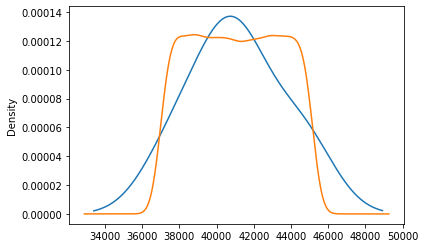

In [ ]:
#visualization subscribertype - user_id
#blue is base
#orange is premium
subscribertype.groupby('subscribertype').User_ID.plot(kind='kde')

# Методы для построения векторных представлений 

Импортируем датасет для этого пункта

In [8]:
#Для удаление не нужных символов в названиях трека
def _convert_to_unicode(text):
    if '%' in text:
        text = urllib.parse.unquote(text)
    return text.replace('+',' ')

Датасет позитивных и негативных *Пользователь - Слушает - Автор*

In [11]:
author_positive = pd.read_csv('/content/id_recomended.csv')
author_negative = pd.read_csv('/content/id_non_recomended.csv')

Датасет *Автор - Имя*

In [12]:
persons = pd.read_csv('/content/persons.csv')

In [13]:
persons['Track_Name'] = persons['Track_Name'].astype(str)
persons['Track_Name'] = persons['Track_Name'].apply(lambda x: _convert_to_unicode(x))
persons = persons.rename(columns={'1':'Author_ID'})
persons['Author_ID'] = persons['Author_ID'].astype(str)

In [14]:
#Удаляем дубликаты колонки - Автор, т.к. по этим данным будет осуществляться оценка похожих авторов, а не названия треков
persons = persons.drop_duplicates(subset=['Author_ID'])

In [15]:
#Создаем листы Автор - Имя и Имя - Автор.
author_track = dict(zip(persons.Author_ID.values, persons.Track_Name.values))
track_author = dict(zip(persons.Track_Name.values, persons.Author_ID.values))

## Подготовка тренировочных и тестовых данных

In [ ]:
#Добавляем рейтинг равный 1 для позитивных данных
author_positive = author_positive.rename(columns={'Author_ID_Recommended':'Author_ID'})
author_positive.insert(2, 'Rating', 1)

In [ ]:
#Добавляем рейтинг равный 0 для негативных данных
author_negative = author_negative.rename(columns={'Author_ID_Non_Recommended':'Author_ID'})
author_negative.insert(2, 'Rating', 0)

In [ ]:
#Создаем общий датасет
authors=author_positive.append(author_negative)

In [ ]:
#Проверяем размер
len(authors)

58173106

In [ ]:
#Удаляем нулевые данные
authors = authors[authors['Author_ID'] != 0]

In [ ]:
#Значения в int
authors['User_ID'] = authors['User_ID'].astype(int)

In [ ]:
#Проверяем размер
len(authors)

57883353

In [ ]:
#Удаляем переменные
del author_positive, author_negative

In [ ]:
# Рандомный вывод 5 записей датасета
for df in list((persons, authors)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx,:])
    print("Displaying 5 of the total "+str(len(df))+" data points")

,Author_ID,Track_Name
232707,297437,Roberto Conrado
383867,52936,Blues Creation
586840,6168,78424325
463608,467182,Kate Royal
273346,318688,Sidonie


Displaying 5 of the total 560927 data points


,User_ID,Author_ID,Rating
29227074,31208,509046,1
18176215,41793,508741,1
8311274,40136,88074,1
1118771,43250,165636,0
3175118,36464,512890,1


Displaying 5 of the total 57883353 data points


В этом пункте необходимо, реализовать несколько методов (простой baseline и более сложную модель) для построения векторных представлений.

**P.S.** Будет плюсом, если вы придумаете, как использовать дополнительную информацию из датасета. Это дополнение реализовано в п. "Протокол оценки качества".


## Тренировочные и тестовые данные

Разделяем данные на тестовые 20% и тренировочные 80%.

In [ ]:
df_ratings_train, df_ratings_test= train_test_split(authors,
                                                    stratify=authors['User_ID'],
                                                    random_state = 4256,
                                                    test_size=0.2)

Количество данных

In [ ]:
print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 46306682
Number of test data: 11576671


Удаляем дубликаты

In [ ]:
df_ratings_train = df_ratings_train.drop_duplicates(subset=['Author_ID','User_ID'])
df_ratings_test = df_ratings_test.drop_duplicates(subset=['Author_ID','User_ID'])

Проверяем количество данных

In [ ]:
print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 5593023
Number of test data: 2718834


## Baseline модель

Применим метод к-ближайших соседей. Метод выбран, по причине того, что алгоритм может быть применим к выборкам с большим количеством атрибутов (многомерным), при взвешанном способе. При взвешенном способе во внимание принимается не только количество попавших в область определённых классов, но и их удалённость от нового значения. С помощью метода можно вычислять значение одного из атрибутов классифицируемого объекта на основании дистанций от попавших в область объектов и соответствующих значений этого же атрибута у объектов.

**Примечания:** Для реализации задачи, нахождения ближайших авторов, подсознательно первое приходи на ум, метод к-ближайших соседей.

In [ ]:
#Переведем значение индекса второв в int
persons['Author_ID'] = persons['Author_ID'].astype(int)

### Подготовка данных

Из-за ограничения RAM, принято несколько решений для подготовки данных, т.к. задуманно перевести для каждого пользователя значения в прослушанных авторов в 1, для применения метода ближайших соседей.

1.	Можно обучить модель на первой части тренировочных данных *5593023/2 = 2796511* и второй части. При этом сохранить лучший результат. (Проделано)
2.	Подготовить данные перед ресурсоемкой операцией, сохранить, сбросить память, и выполнит ресурскоемкую операцию. (Проделано)
3.	Сократить данные. (Нет необходимости)

**Примечание:** Ниже решение для п.2, т.к. вариант наиболее желательный для реализации.


In [ ]:
#Объединим данные Автор-Пользователь с Названием трека
df = pd.merge(df_ratings_train,persons,on='Author_ID')
df.head()

,User_ID,Author_ID,Rating,Track_Name
0,21819,287606,1,The Ramones
1,33399,287606,0,The Ramones
2,22368,287606,1,The Ramones
3,40011,287606,1,The Ramones
4,15495,287606,1,The Ramones


In [ ]:
#Сложим рейтинг для Авторов
combine_artist_rating = df.dropna(axis = 0, subset = ['Track_Name'])
artist_ratingCount = (combine_artist_rating.
     groupby(by = ['Track_Name'])['Rating'].
     count().
     reset_index().
     rename(columns = {'Rating': 'Total_Rating_Count'})
     [['Track_Name', 'Total_Rating_Count']]
    )
artist_ratingCount.head()

,Track_Name,Total_Rating_Count
0,! H,1
1,! WWW.POLSKIE-MP3.TK ! czerwono-czarni,1
2,! WWW.POLSKIE-MP3.TK ! lista przebojow program...,1
3,! WWW.POLSKIE-MP3.TK ! niebiesko-czarni,1
4,! WWW.POLSKIE-MP3.TK ! proleta,1


In [ ]:
#Добавим столбец с общим рейтингом Автора
rating_with_totalRatingCount = combine_artist_rating.merge(artist_ratingCount, left_on = 'Track_Name', right_on = 'Track_Name', how = 'left')
rating_with_totalRatingCount.head()

,User_ID,Author_ID,Rating,Track_Name,Total_Rating_Count
0,21819,287606,1,The Ramones,2334
1,33399,287606,0,The Ramones,2334
2,22368,287606,1,The Ramones,2334
3,40011,287606,1,The Ramones,2334
4,15495,287606,1,The Ramones,2334


In [ ]:
#Оценим датасет
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(artist_ratingCount['Total_Rating_Count'].describe())

count   499258.000
mean        11.203
std        100.667
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       8473.000
Name: Total_Rating_Count, dtype: float64


In [ ]:
#Добавим порог популярности, чтобы откинуть совсем не прослушиваемых Авторов
popularity_threshold = 50
rating_popular_artist= rating_with_totalRatingCount.query('Total_Rating_Count >= @popularity_threshold')
rating_popular_artist.head()

,User_ID,Author_ID,Rating,Track_Name,Total_Rating_Count
0,21819,287606,1,The Ramones,2334
1,33399,287606,0,The Ramones,2334
2,22368,287606,1,The Ramones,2334
3,40011,287606,1,The Ramones,2334
4,15495,287606,1,The Ramones,2334


In [ ]:
#Оценим размер
rating_popular_artist.shape

(4042667, 5)

In [ ]:
#Сохраняем данные перед ресурсоемкой операции, и сбрасываем память 
rating_popular_artist.to_csv('rating_popular_artist')

In [ ]:
#Импортируем данные
rating_popular_artist = pd.read_csv('/content/rating_popular_artist')

In [ ]:
#Удаляем не нужный столбец
rating_popular_artist = rating_popular_artist.drop(columns=['Unnamed: 0'])

In [ ]:
#Создаем Pivot Мatrix для пользователей

artist_features_df=rating_popular_artist.pivot_table(index='Track_Name',columns='User_ID',values='Rating').fillna(0)

In [ ]:
artist_features_df.head()

User_ID,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,41,42,43,...,45135,45136,45137,45138,45139,45140,45141,45142,45143,45144,45145,45146,45147,45148,45149,45150,45151,45152,45153,45154,45155,45156,45157,45158,45160,45161,45162,45163,45164,45165,45166,45167,45168,45169,45170,45171,45172,45173,45174,45175
Track_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!!!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Weird Al"" Yankovic & Wendy Carlos",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1 Dads,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%2B/-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%2B44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Обучение модели KNN

In [ ]:
#from scipy.sparse import csr_matrix

artist_features_df_matrix = csr_matrix(artist_features_df.values)

#from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(artist_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
#Сохраняем модель
joblib.dump(model_knn, 'model_knn')

['model_knn']

In [ ]:
#Импортируем модель
model_knn = joblib.load('/content/model_knn')

In [ ]:
#Индексируемая строка
query_index = np.random.choice(artist_features_df.shape[0])
print(query_index)

7786


In [ ]:
#Индекс- Имя автора
name_index = artist_features_df.reset_index()

In [ ]:
#Выбираем автора, для нахождение топ 20 похожиш авторов
query_index = name_index[name_index['Track_Name'] == 'Lenny Kravitz & Asa'].index.item()
print(query_index)

7341


In [ ]:
#Определяем дистанцию между авторами
distances, indices = model_knn.kneighbors(artist_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 21)

In [ ]:
#Вывод топ 20 похожих авторов
b_cell = []
bas_list = []
for i in range(0, len(distances.flatten())):
  authorID = persons['Author_ID'][persons['Track_Name'] == artist_features_df.index[indices.flatten()[i]]].values.tolist()
  b_cell = authorID, artist_features_df.index[indices.flatten()[i]], distances.flatten()[i]
  bas_list.append(b_cell)
print('Recommendations for {0}:\n'.format(artist_features_df.index[query_index]), pd.DataFrame(bas_list, columns=['Author_ID', 'Track_Name', 'Distance']).drop([0]))

Recommendations for Lenny Kravitz & Asa:
    Author_ID                        Track_Name  Distance
1   [290797]           Red Hot Chili Peppers -  0.821974
2   [154295]                      Foo Figthers  0.834427
3    [82955]          Coldplay & Kylie Minogue  0.836140
4   [386379]                    U2 & Bob Dylan  0.838085
5   [124222]               Queen & The Muppets  0.844453
6    [11423]                         Aerosmith  0.845939
7   [252849]                  Nirvana-in utero  0.846021
8   [184540]                     Kings of Leon  0.847885
9    [53169]                  Blur & Offspring  0.852981
10  [171499]                         Green Day  0.853068
11  [257088]                             Oasis  0.853298
12  [371194]                             Verve  0.853936
13  [292035]                            R.E.M.  0.853939
14  [219254]              Maroon 5 Ft. Rihanna  0.855664
15  [286091]                     RadioheadNCON  0.859707
16  [229444]  Michael Jackson & Siedah Garrett

### Экспериментальная часть

#### Подготовка строки данных

В это части мне бы хотелось совершить поиск похожести для одного **нового** автора из тестового датасета

In [ ]:
#Для сравнения наличия всех столбцов из обученной модели, одна строка из artist_features_df (датасет на котором обучалась модель)
artist_features_df[1000:1001].to_csv('baseline_prediction_row')

Берем данные для предсказаний

In [ ]:
#Рандомный выбор индекса автора из тестового датасета
authorID = df_ratings_test.iloc[np.random.choice(df_ratings_test.shape[0])]['Author_ID']

In [ ]:
#Данные из тестового датасета от рандомного автора
prediction = df_ratings_test[df_ratings_test['Author_ID'] == authorID]
prediction.head()

,User_ID,Author_ID,Rating
26878935,26908,375121,1
14460917,16615,375121,0
2636260,3561,375121,0
12501844,39176,375121,0
16614054,41700,375121,0


In [ ]:
#Установим название Автора
persons['Track_Name'][persons['Author_ID'] == authorID].item()

'Till Von Sein'

In [ ]:
#Объеденим в один датасет
prediction.insert(2, 'Track', persons['Track_Name'][persons['Author_ID'] == authorID].item())

In [ ]:
prediction.head()

,User_ID,Author_ID,Track,Rating
26878935,26908,375121,Till Von Sein,1
14460917,16615,375121,Till Von Sein,0
2636260,3561,375121,Till Von Sein,0
12501844,39176,375121,Till Von Sein,0
16614054,41700,375121,Till Von Sein,0


In [ ]:
#Создаем Pivot Мatrix
prediction_df=prediction.pivot_table(index='Track',columns='User_ID',values='Rating').fillna(0)
prediction_df.head()

User_ID,2959,3561,6548,6669,7367,7405,9940,14641,16615,17302,17638,17987,18250,25782,26047,26054,26908,27742,28643,30543,31455,31626,32003,33895,34570,36317,39176,41700
Track,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Till Von Sein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [ ]:
#Сохраним данные для дальнейшего исследования
prediction_df.to_csv('prediction_df_row')

#### Предсказание

In [ ]:
#Импортируем
baseline_prediction_row = pd.read_csv('/content/baseline_prediction_row')
prediction_df = pd.read_csv('/content/prediction_df_row')

In [ ]:
#Назовем столбец
prediction_df = prediction_df.append(baseline_prediction_row.rename(columns={'Track_Name':'Track'}))

In [ ]:
#Имя автора как индекс
prediction_df = prediction_df.set_index('Track')

Проверяем, присутствие в обученной модели всех столбцов из датасета в случае, если данные из тестового датасета, будут содержать столбцы, которых нет в обученной модели, эти столбцы нужно удалить.

In [ ]:
test[1:2].columns[test[1:2].isnull().any()].tolist()

[]

In [ ]:
#Nan в 0
prediction_df[prediction_df.isnull()] = 0

In [ ]:
#Совершаем предсказание
distance = model_knn.kneighbors(prediction_df.iloc[0:1].values.reshape(1, -1), n_neighbors = 21)

In [ ]:
#Создадим список топ 20 похожих авторов
b_cell = []
bas_list = []
for i in range(0,21):
  authorID = persons[persons['Author_ID'] == distance[1][0][i]]['Track_Name'].values.tolist()
  b_cell = distance[1][0][i], authorID, distance[0][0][i]                        
  bas_list.append(b_cell) 
print('Recommendations for {0}:\n'.format(prediction_df.iloc[0].name), pd.DataFrame(bas_list, columns=['Author_ID', 'Track_Name', 'Distance']).drop([0]))

Recommendations for Till Von Sein:
     Author_ID                                 Track_Name  Distance
1          70                                      [(01]  0.888889
2        8710                             [Accelerators]  0.890891
3        3768                    [311 (The Clash cover)]  0.890891
4        3502                    [2Pac f. Deadly Threat]  0.892789
5         300                              [02. Roxanne]  0.892789
6       10026                    [Adam Shaw & Tim Weeks]  0.899496
7         196                [01. When The Children Cry]  0.902410
8        8337                                  [Abstain]  0.903775
9        9712                              [Adam Bohman]  0.905084
10       7374            [Aasha Bhosle f. Apache Indian]  0.907550
11       8935  [Ach ich hab in meinem Herzen da drinnen]  0.909833
12      10955         [Adriano Mattioli and Elias Funes]  0.910913
13      11929                                 [Afrokats]  0.911955
14       7603             

## Сложная модель word2vec (item2vec)

Чтобы наша модель выучила встраивание, нам нужно получить эквиваленты «слова» и «предложения» из данных. Здесь вы можете представить, что каждое имя автора - это слово, а авторы, получившие положительные оценки от пользователя, находятся в одном и том же «предложении».
В частности, «предложения» генерируются с помощью процесса, описанного ниже: Для каждого пользователя сгенерируйте 2 списка, в которых соответственно хранятся авторы «Понравилось» и «Не понравилось» пользователем. Первый список содержит всех авторов с оценкой 1. Второй список содержит остальных. 

Эти списки являются входными данными для обучения модели **Gensim Word2Vec.**
Следующий код делает то, что было сказано выше:

In [ ]:
def rating_splitter(df):
    
    df['Liked'] = np.where(df['Rating'] == 1, 1, 0) #Понравилось == 1
    df['Author_ID'] = df['Author_ID'].astype('str')
    gp_user_like = df.groupby(['Liked', 'User_ID'])

    return ([gp_user_like.get_group(gp)['Author_ID'].tolist() for gp in gp_user_like.groups])

In [ ]:
#Генерируем списки
pd.options.mode.chained_assignment = None
splitted_track = rating_splitter(df_ratings_train)

**Обучение модели с Gensim**

В этом разделе мы введем данные обучения в  **Gensim Word2Vec.** 

Для оригинального Word2Vec размер окна влияет на область, которую мы искали для «контекстов», чтобы определить значение данного слова. Как это определено, окно имеет фиксированный размер. Однако в нашей реализации Item2Vec «значение» автора должно быть зафиксировано всеми его соседями в одном списке. Другими словами, мы должны рассмотреть всех авторов, «понравившиеся» пользователю. Это относится и ко всем авторам, которые не нравятся пользователю. Размер окна необходимо изменить в соответствии с размером каждого списка авторов.
Чтобы решить эту проблему, не изменяя базовый код модели **Gensim**, мы сначала указываем очень очень большой размер окна, который намного больше, чем длина любых списков автора. Затем мы перетасовываем наши тренировочные данные перед подачей их в модель, потому что порядок авторов не имеет смысла при определении «значения» автора с использованием его соседей.
Параметр окна в модели **Gensim** фактически является случайной динамикой. Мы указываем максимальный размер окна вместо фактического используемого размера окна. Хотя обходной путь выше не идеален, он достигает приемлемой производительности. Наилучшим подходом может быть непосредственное изменение базового кода в **Gensim**, но это выходит за рамки данного задания.

Последнее, что нужно сделать перед тем, как приступить к обучению этому режиму, - убедиться, что **Gensim** использует компилятор C, для проверки этого запустите приведенный ниже код:

In [ ]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

Приведенный ниже код перемешивает данные обучения:

In [ ]:
#import random

for track_list in splitted_track:
    random.shuffle(track_list)

### Обучение модели по гипермараметрам

Код ниже обучает модель с выбранными гиперпараметрами. Обучение модели может занять некоторое время. 

In [ ]:
#from gensim.models import Word2Vec
#import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = splitted_track, #Мы предоставим предварительно обработанный список автора для этого параметра.
                 iter = 5, #Повторений
                 min_count = 10, #Автор должен появляться более 10 раз, чтобы его сохранить
                 size = 200, #Размер скрытого слоя
                 workers = 4, #Количество потоков, которые будут использоваться для обучения
                 sg = 1, #Определяет алгоритм обучения. Мы будем использовать скип-грамм, поэтому выбрано 1.
                 hs = 0, #Установите в 0, так как мы применяем отрицательную выборку.
                 negative = 5, #Если> 0, будет использоваться отрицательная выборка. Мы будем использовать значение 5.
                 window = 9999999) #Размер окна

print("Time passed: " + str(datetime.datetime.now()-start))

Time passed: 1:21:31.270480


In [ ]:
model.save('item2vec_202006_1') #Сохраняем обученную модель

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


После обучения модель сохраняется для дальнейшего применения. Обратите внимание, что **Gensim** сохранил всю информацию о модели, включая скрытые веса, частоту словарного запаса и двоичное дерево модели, поэтому можно продолжить обучение после загрузки файла. Однако это происходит за счет памяти при запуске модели. Если все, что вам нужно, это скрытый вес, его можно извлечь из модели отдельно. 

Следующий код демонстрирует, как сохранить, загрузить модель и извлечь векторы слов.

In [ ]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_202006_1')
word_vectors = model.wv
#del model #Удалим модель

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#Имя артиста в вид ['Индекс автора 1','Индекс автора 2'...'Индекс автора n']
def artist_name(name):
  a_cell = []
  artist_list=[]
  for i in range(len(name)):
    a_cell = track_author[name[i]]
    artist_list.append(a_cell)
  return(artist_list)

In [ ]:
#Создаем топ лист для 20 похожих авторов
def toplist(test):
  t_cell = []
  top_list = []
  for i in range(len(test)):
    t_cell = persons[persons["Author_ID"].isin(test[i])]
    top_list.append(t_cell)
  top = pd.concat(top_list)
  return(top)

In [ ]:
w1 = 'Lenny Kravitz & Asa', 'Nicole Kidman/Robbie Williams'
w2 = 'Dido & Enya', #Если одно название автора, необходимо поставить в конце ',' чтобы длина = 1 (колличество авторов), иначе длина = длине слова
print('Top 20 list')
toplist(test = model.wv.most_similar (positive = artist_name(w1), negative = artist_name(w2), topn = 20))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Author_ID,Track_Name
50834,386379,U2 & Bob Dylan
489323,53169,Blur & Offspring
29413,124222,Queen & The Muppets
205143,11423,Aerosmith
305273,464493,Kaiser Chiefs
105140,290797,Red Hot Chili Peppers -
69606,174126,Guns 'N' Roses
38574,299571,Rolling Stones
132062,60190,Bruce Springsteen & The E Street Band with Tom...
50779,29427,Arctic Monekys


## Экспрементальная часть

В экспериментальной части, я решил преобразовать датасет позитивных рекомендаций, таким образом, чтобы, если один пользователь слушал "Автор 1" - 5 раз, а "Автор 2" - 2 раза, рейтинг у них был бы не равносильный, а равен 5 и 2 соответственно. При этом рейтинг негативных рекомендаций, равен также 0. 

*Таким образом, учитывался бы рейтинг качества треков автора, помимо часто-встречаемости.*


Заново выполнить запуск **пункта** *Методы для построения векторыных представлений*, в частности с **импортирование датасетов** до создания листа **Автор - Имя**

In [16]:
#Добавление колонки с рейтингом 1 для позитивных рекомендаций
author_positive = author_positive.rename(columns={'Author_ID_Recommended':'Author_ID'})
author_positive.insert(2, 'Rating', 1)

In [17]:
#Если строка: Пользователь - Автор, повторяется, тогда колонка "Рейтинг" складывается.
author_positive = author_positive.groupby(['Author_ID','User_ID']).agg({'Rating': 'sum'})

In [18]:
#Вернуть колонки Пользователь - Автор
author_positive = author_positive.reset_index()

In [19]:
#Результат
author_positive.head()

,Author_ID,User_ID,Rating
0,0,1,1
1,0,2,14
2,0,3,3
3,0,4,1
4,0,5,8


In [20]:
#Добавим рейтинг 0 для негативных рекомендаций
author_negative = author_negative.rename(columns={'Author_ID_Non_Recommended':'Author_ID'})
author_negative.insert(2, 'Rating', 0)

In [21]:
#Создаем общий датасет
authors=author_positive.append(author_negative)

In [22]:
#Удаляем нулевые строки
authors = authors[authors['Author_ID'] != 0]

In [23]:
#Значения в int
authors['User_ID'] = authors['User_ID'].astype(int)

In [24]:
#Удаляем не нужные пермененные
del author_positive, author_negative

In [26]:
#Рандомный вывод 5 строк
for df in list((persons, authors)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx,:])
    print("Displaying 5 of the total "+str(len(df))+" data points")

,Author_ID,Track_Name
529911,358335,The Heavy Hearts
558240,434249,Honey is Cool
349876,531738,K Camp ft PeeWee Longway
575234,102041,Daniel Caesar
265959,225917,Megafaun with Adam Heathcott (Reactable Mobile)


Displaying 5 of the total 560927 data points


,Author_ID,User_ID,Rating
18424694,467679,7860,0
3263412,428974,34013,0
452022,44182,14799,19
8493016,111129,17550,0
6249898,401676,22958,0


Displaying 5 of the total 28109806 data points


### Тренировочные и тестовые данные

Разделяем данные на тестовые 20% и тренировочные 80%.

In [27]:
df_ratings_train, df_ratings_test= train_test_split(authors,
                                                    stratify=authors['User_ID'],
                                                    random_state = 4256,
                                                    test_size=0.2)

Количество данных

In [28]:
print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 22487844
Number of test data: 5621962


Удаляем дубликаты

In [29]:
df_ratings_train = df_ratings_train.drop_duplicates(subset=['Author_ID','User_ID'])
df_ratings_test = df_ratings_test.drop_duplicates(subset=['Author_ID','User_ID'])

Количество данных

In [30]:
print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 5411812
Number of test data: 2211256


In [ ]:
def rating_splitter(df):
    
    df['Liked'] = np.where(df['Rating'] >= 1, 1, 0) #Важно, чтобы рейтинг был >= 1
    df['Author_ID'] = df['Author_ID'].astype('str')
    gp_user_like = df.groupby(['Liked', 'User_ID'])

    return ([gp_user_like.get_group(gp)['Author_ID'].tolist() for gp in gp_user_like.groups])

In [ ]:
#Генерируем списки
pd.options.mode.chained_assignment = None
splitted_track = rating_splitter(df_ratings_train)

Убедимся, что **Gensim** использует компилятор 

In [ ]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

Перемешиваем данные для обучения

In [ ]:
#import random

for track_list in splitted_track:
    random.shuffle(track_list)

### Обучение модели по гипермараметрам

In [ ]:
#from gensim.models import Word2Vec
#import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = splitted_track, #Мы предоставим предварительно обработанный список автора для этого параметра.
                 iter = 5, # Повторений
                 min_count = 10, #Автор должен появляться более 10 раз, чтобы его сохранить
                 size = 200, #Размер скрытого слоя
                 workers = 4, #Количество потоков, которые будут использоваться для обучения
                 sg = 1, #Определяет алгоритм обучения. Мы будем использовать скип-грамм, поэтому выбрано 1.
                 hs = 0, #Установите в 0, так как мы применяем отрицательную выборку.
                 negative = 5, #Если> 0, будет использоваться отрицательная выборка. Мы будем использовать значение 5.
                 window = 9999999) #Размер окна

print("Time passed: " + str(datetime.datetime.now()-start))

In [ ]:
model.save('item2vec_202006_2') #Сохраняем модель

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Импортируем обученную модель

In [ ]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_202006_2')
word_vectors = model.wv
# del model #Удаление импортированной модели

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Приведем список 20 похожих авторов, по поведению пользователя, при этом необходимо запустить парсеры artist_name и toplist из предыдущей модели

In [ ]:
w1 = 'Lenny Kravitz & Asa', 'Nicole Kidman/Robbie Williams'
w2 = 'Dido & Enya', #must to set ',' to len(name) = 1, else len(name) = len phrase
toplist(test = model.wv.most_similar (positive = artist_name(w1), negative = artist_name(w2), topn = 20))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Author_ID,Track_Name
32678,257088,Oasis
96872,154295,Foo Figthers
363958,466633,Kasabian
99514,452151,Jet
205143,11423,Aerosmith
290919,460815,Journey
105140,290797,Red Hot Chili Peppers -
29413,124222,Queen & The Muppets
489323,53169,Blur & Offspring
50834,386379,U2 & Bob Dylan


В сравнении с моделю рейтинг 1 и 0, совпадений 9 из 20.

Снова обучим модель, но с другими гиперпараметрами

In [ ]:
#from gensim.models import Word2Vec
#import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = splitted_track, #Мы предоставим предварительно обработанный список автора для этого параметра.
                 iter = 10, #Повторений
                 min_count = 10, #Автор должен появляться более 10 раз, чтобы его сохранить
                 size = 300, #Размер скрытого слоя
                 workers = 4, #Количество потоков, которые будут использоваться для обучения
                 sg = 1, #Определяет алгоритм обучения. Мы будем использовать скип-грамм, поэтому выбрано 1.
                 hs = 0, #Установите в 0, так как мы применяем отрицательную выборку.
                 negative = 5, #Если> 0, будет использоваться отрицательная выборка. Мы будем использовать значение 5.
                 window = 9999999) #Размер окна

print("Time passed: " + str(datetime.datetime.now()-start))

Time passed: 3:33:26.231159


In [ ]:
model.save('item2vec_202006_3') #Сохраняем модель

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Импортируем модель

In [ ]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_202006_3')
word_vectors = model.wv
# del model #Удаление модели

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Приведем список 20 похожих авторов, по поведению пользователя, при этом необходимо запустить парсеры artist_name и toplist из предыдущей модели

In [ ]:
w1 = 'Lenny Kravitz & Asa', 'Nicole Kidman/Robbie Williams'
w2 = 'Dido & Enya', #must to set ',' to len(name) = 1, else len(name) = len phrase
toplist(test = model.wv.most_similar (positive = artist_name(w1), negative = artist_name(w2), topn = 20))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Author_ID,Track_Name
50834,386379,U2 & Bob Dylan
32678,257088,Oasis
205143,11423,Aerosmith
96872,154295,Foo Figthers
489323,53169,Blur & Offspring
105140,290797,Red Hot Chili Peppers -
194162,70915,Creedence Clearwater Revival
290919,460815,Journey
29413,124222,Queen & The Muppets
363958,466633,Kasabian


В сравнении с моделю этого же датасета, но с другими гиперпараметрами, совпадений 13 из 20.

# Оценка моделей

Статистически сравнить модели item2vec.

## Статистическая оценка

Статистическая оценка модели item2vec (1).

Данные с рейтингом 0 и 1.

Гиперпараметры: 
1. Повторений 5 (iter = 5).
2. Автор должен появляться более 10 раз, чтобы его сохранить (min_count = 10).
3. Размер скрытого слоя 200 (size = 200).
4. Количество потоков 4, которые  использовали для обучения (workers = 4)
5. Определяет алгоритм обучения. Мы  использовали скип-грамм, поэтому выбрано 1, (sg = 1).
6. Поставили в 0, так как мы применяем отрицательную выборку, (hs = 0).
7. Применялась отрицательная выборка. Мы использовали значение 5, (negative = 5).
8. Размер окна, максимальный, чтобы не подбирать его (window = 9999999).
  
**Примечание:** df_ratings_train и df_ratings_test необходимо получить по шагам из п."Тренировочные и тестовые данные".

In [ ]:
def user_likes_author(model, df, for_prediction=False):
    df['Liked'] = np.where(df['Rating']==1, 1, 0)
    df['Author_ID'] = df['Author_ID'].astype('str')
    df_liked = df[df['Liked']==1]
    if for_prediction:
        df_liked = df[df['Author_ID'].isin(model.wv.vocab.keys())]
        
    user_liked = df_liked.groupby('User_ID').agg({'Author_ID': lambda x: x.tolist()})['Author_ID'].to_dict()
    
    return user_liked

def scores_at_m (model, user_liked_test, user_liked_training, topn=20):
    sum_liked = 0
    sum_correct = 0
    sum_total = 0
    common_users = set(user_liked_test.keys()).intersection(set(user_liked_training.keys()))

    for userid in common_users:
        current_test_set = set(user_liked_test[userid])
        pred = [pred_result[0] for pred_result in model.wv.most_similar_cosmul(positive = user_liked_training[userid], topn=topn)]
        sum_correct += len(set(pred).intersection(current_test_set))
        sum_liked += len(current_test_set)
    precision_at_m = sum_correct/(topn*len(common_users))
    recall_at_m = sum_correct/sum_liked
    f1 = 2/((1/precision_at_m)+(1/recall_at_m))
    return [precision_at_m, recall_at_m, f1]

In [ ]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_202006_1')
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Определим precision, recall, F-1 score для 20 похожих.

In [ ]:
#import datetime
start = datetime.datetime.now()

pd.options.mode.chained_assignment = None
user_liked_train = user_likes_author(model, df_ratings_train, for_prediction=True)
user_liked_test = user_likes_author(model, df_ratings_test)

model = Word2Vec.load('item2vec_202006_1')
model_score_sg1 = scores_at_m(model, user_liked_test, user_liked_train)
del model

print("Time passed: " + str(datetime.datetime.now()-start))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Time passed: 3:02:29.437395
Time passed: 3:02:29.437395


In [ ]:
print("Respectively, the [precision, recall, F-1 score] at 20 for our model are:")
print(model_score_sg1)

Respectively, the [precision, recall, F-1 score] at 20 for our model are:
[0.012984031014907462, 0.007581984885889544, 0.009573534065889192]
Respectively, the [precision, recall, F-1 score] at 20 for our model are:
[0.012984031014907462, 0.007581984885889544, 0.009573534065889192]
Respectively, the [precision, recall, F-1 score] at 20 for our model are:
[0.012984031014907462, 0.007581984885889544, 0.009573534065889192]


Статистическая оценка модели item2vec (2).

Данные с рейтингом 0 и >1 (суммарный рейтинг).

Гиперпараметры: 
1. Повторений 5 (iter = 5).
2. Автор должен появляться более 10 раз, чтобы его сохранить (min_count = 10).
3. Размер скрытого слоя 200 (size = 200).
4. Количество потоков 4, которые  использовали для обучения (workers = 4)
5. Определяет алгоритм обучения. Мы  использовали скип-грамм, поэтому выбрано 1, (sg = 1).
6. Поставили в 0, так как мы применяем отрицательную выборку, (hs = 0).
7. Применялась отрицательная выборка. Мы использовали значение 5, (negative = 5).
8. Размер окна, максимальный, чтобы не подбирать его (window = 9999999).
  
**Примечание:** df_ratings_train и df_ratings_test необходимо получить по шагам из п."Эксперементальная часть/Обучение по гиперпараметрам".

In [31]:
def user_likes_author(model, df, for_prediction=False):
    df['Liked'] = np.where(df['Rating']>=1, 1, 0)
    df['Author_ID'] = df['Author_ID'].astype('str')
    df_liked = df[df['Liked']==1]
    if for_prediction:
        df_liked = df[df['Author_ID'].isin(model.wv.vocab.keys())]
        
    user_liked = df_liked.groupby('User_ID').agg({'Author_ID': lambda x: x.tolist()})['Author_ID'].to_dict()
    
    return user_liked

def scores_at_m (model, user_liked_test, user_liked_training, topn=20):
    sum_liked = 0
    sum_correct = 0
    sum_total = 0
    common_users = set(user_liked_test.keys()).intersection(set(user_liked_training.keys()))

    for userid in common_users:
        current_test_set = set(user_liked_test[userid])
        pred = [pred_result[0] for pred_result in model.wv.most_similar_cosmul(positive = user_liked_training[userid], topn=topn)]
        sum_correct += len(set(pred).intersection(current_test_set))
        sum_liked += len(current_test_set)
    precision_at_m = sum_correct/(topn*len(common_users))
    recall_at_m = sum_correct/sum_liked
    f1 = 2/((1/precision_at_m)+(1/recall_at_m))
    return [precision_at_m, recall_at_m, f1]

In [ ]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_202006_2')
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Определим precision, recall, F-1 score для 20 похожих.

In [ ]:
pd.options.mode.chained_assignment = None
user_liked_train = user_likes_author(model, df_ratings_train, for_prediction=True)
user_liked_test = user_likes_author(model, df_ratings_test)

model = Word2Vec.load('item2vec_202006_2')
model_score_sg1 = scores_at_m(model, user_liked_test, user_liked_train)
del model

In [ ]:
print("Respectively, the [precision, recall, F-1 score] at 20 for our model are:")
print(model_score_sg1)

Respectively, the [precision, recall, F-1 score] at 20 for our model are:
[0.025951735553050113, 0.030297811085719408, 0.027956875321406515]


Статистическая оценка модели item2vec (3).

Данные с рейтингом 0 и >1 (суммарный рейтинг).

Гиперпараметры: 
1. Повторений 10 (iter = 10).
2. Автор должен появляться более 10 раз, чтобы его сохранить (min_count = 10).
3. Размер скрытого слоя 300 (size = 300).
4. Количество потоков 4, которые  использовали для обучения (workers = 4)
5. Определяет алгоритм обучения. Мы  использовали скип-грамм, поэтому выбрано 1, (sg = 1).
6. Поставили в 0, так как мы применяем отрицательную выборку, (hs = 0).
7. Применялась отрицательная выборка. Мы использовали значение 5, (negative = 5).
8. Размер окна, максимальный, чтобы не подбирать его (window = 9999999).
  
**Примечание:** df_ratings_train и df_ratings_test необходимо получить по шагам из п."Эксперементальная часть/Обучение по гиперпараметрам".

In [32]:
#import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_202006_3')
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Определим precision, recall, F-1 score для 20 похожих.

In [ ]:
import datetime
start = datetime.datetime.now()

pd.options.mode.chained_assignment = None
user_liked_train = user_likes_author(model, df_ratings_train, for_prediction=True)
user_liked_test = user_likes_author(model, df_ratings_test)

model = Word2Vec.load('item2vec_202006_3')
model_score_sg1 = scores_at_m(model, user_liked_test, user_liked_train)
del model

print("Time passed: " + str(datetime.datetime.now()-start))

In [ ]:
print("Respectively, the [precision, recall, F-1 score] at 20 for our model are:")
print(model_score_sg1)

Respectively, the [precision, recall, F-1 score] at 20 for our model are:
[0.026630604265118624, 0.03109036832907649, 0.028688196273105735]


Сравнивая модели item2vec (1) и (2) по recall, pression, f1 score, выявлено, что модель item2vec (2), более точная, т.к. рейтинг авторов в датасета, на котором обучалась модель равнялся >1, что уменьшало процент похожести для большинства авторов. 

**Можно судить, что точность item2vec(2) > точности item2vec (1) в 2 раза.**

**Можно судить, что чувствительность item2vec(2) > чувствительности item2vec (1) в 4 раза.**

**Можно судить, что оценка f1 item2vec(2) > оценки f1 item2vec (1) в 2.92 раза.**

Сравнивая модели item2vec (2) и (3) по recall, pression, f1 score, выявлено, что модель item2vec (3), более точная, т.к. как и предполагалось ранее, ведь размер внутреннего слоя внушительно больше, size 300 и повторений inter 10. 

**Можно судить, что точность item2vec(3) > точности item2vec (2) на 2.6%.**

**Можно судить, что чувствительность item2vec(2) > чувствительности item2vec (1) на 2,6%.**

**Можно судить, что оценка f1 item2vec(2) > оценки f1 item2vec (1) на 2,6%.**



## Результативная оценка

Сравним результаты выдачи, всех моделей для Lenny Kravitz & Asa. 

Примечание: Характеристики моделей item2vec (number), можно посмотреть в п. (Статистическая оценка), под тем же (number).

In [ ]:
w1 = 'Lenny Kravitz & Asa', 

Результат item2vec (1) модели только для Lenny Kravitz & Asa.

In [ ]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

model = Word2Vec.load('item2vec_202006_1')
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
item2veck_1 = toplist(test = model.wv.most_similar (positive = artist_name(w1), topn = 20))
item2veck_1 = item2veck_1.reset_index().drop(columns=['index','Author_ID']).rename(columns={'Track_Name':'item2vec_1'})

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Результат item2vec (2) модели только для Lenny Kravitz & Asa.

In [ ]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

model = Word2Vec.load('item2vec_202006_2')
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
item2veck_2 = toplist(test = model.wv.most_similar (positive = artist_name(w1), topn = 20))
item2veck_2 = item2veck_2.reset_index().drop(columns=['index','Author_ID']).rename(columns={'Track_Name':'item2vec_2'})

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Результат item2vec (3) модели только для Lenny Kravitz & Asa.

In [ ]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

model = Word2Vec.load('item2vec_rating_pro')
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
item2veck_3 = toplist(test = model.wv.most_similar (positive = artist_name(w1), topn = 20))
item2veck_3 = item2veck_3.reset_index().drop(columns=['index','Author_ID']).rename(columns={'Track_Name':'item2vec_3'})

Результаты model knn взяты из п.(Baseline модель/Обучение модели KNN) для Lenny Kravitz & Asa.

In [ ]:
baseline_knn = np.array([['Red Hot Chili Peppers -','Foo Figthers','Coldplay & Kylie Minogue','U2 & Bob Dylan','Queen & The Muppets','Aerosmith','Nirvana-in utero','Kings of Leon','Blur & Offspring','Green Day','Oasis','Verve','R.E.M.','Maroon 5 Ft. Rihanna','RadioheadNCON','Michael Jackson & Siedah Garrett','Cranberries','No Doubt f/Lady Saw',' Offspring','Muse - Absolution']])

In [ ]:
baseline_knn = pd.DataFrame(baseline_knn).transpose().rename(columns={0:'KNN'})

Приведем полученные результаты из предыдущих разделов на основе рекомендации Lenny Kravitz & Asa.

In [ ]:
pd.concat([baseline_knn, item2veck_1, item2veck_2,item2veck_3], axis=1, sort=False)

,KNN,item2vec_1,item2vec_2,item2vec_3
0,Red Hot Chili Peppers -,U2 & Bob Dylan,Oasis,Oasis
1,Foo Figthers,Santana & Wyclef feat. Avicii & Alexandre Pires,Eagle Eye Cherry,U2 & Bob Dylan
2,Coldplay & Kylie Minogue,Aerosmith,Cranberries,Blur & Offspring
3,U2 & Bob Dylan,Oasis,Alanis Morrisette,Aerosmith
4,Queen & The Muppets,Verve,Foo Figthers,Incubus
5,Aerosmith,Nicole Kidman/Robbie Williams,Verve,R.E.M.
6,Nirvana-in utero,Red Hot Chili Peppers -,Dire Straights,Foo Figthers
7,Kings of Leon,Michael Jackson & Siedah Garrett,Jet,Cranberries
8,Blur & Offspring,Jet,Blur & Offspring,Red Hot Chili Peppers -
9,Green Day,Blur & Offspring,U2 & Bob Dylan,Verve


Количество совпадений "Топ 20 Авторов" между KNN и item2vec(1) = 10.

In [ ]:
pd.merge(baseline_knn, item2veck_1, how='left', left_on='KNN', right_on='item2vec_1').drop(columns = ['KNN']).dropna()

,item2vec_1
0,Red Hot Chili Peppers -
3,U2 & Bob Dylan
4,Queen & The Muppets
5,Aerosmith
8,Blur & Offspring
10,Oasis
11,Verve
12,R.E.M.
15,Michael Jackson & Siedah Garrett
16,Cranberries


Количество совпадений "Топ 20 Авторов" между KNN и item2vec(2) = 9.

In [ ]:
pd.merge(baseline_knn, item2veck_2, how='left', left_on='KNN', right_on='item2vec_2').drop(columns = ['KNN']).dropna()

,item2vec_2
0,Red Hot Chili Peppers -
1,Foo Figthers
3,U2 & Bob Dylan
5,Aerosmith
8,Blur & Offspring
10,Oasis
11,Verve
12,R.E.M.
16,Cranberries


Количество совпадений "Топ 20 Авторов" между KNN и item2vec(3) = 12.

In [ ]:
pd.merge(baseline_knn, item2veck_3, how='left', left_on='KNN', right_on='item2vec_3').drop(columns = ['KNN']).dropna()

,item2vec_3
0,Red Hot Chili Peppers -
1,Foo Figthers
3,U2 & Bob Dylan
5,Aerosmith
7,Kings of Leon
8,Blur & Offspring
10,Oasis
11,Verve
12,R.E.M.
15,Michael Jackson & Siedah Garrett


Количество совпадений "Топ 20 Авторов" между item2vec(1) и item2vec(2) = 13.

In [ ]:
pd.merge(item2veck_1, item2veck_2, how='left', left_on='item2vec_1', right_on='item2vec_2').drop(columns = ['item2vec_1']).dropna()

,item2vec_2
0,U2 & Bob Dylan
2,Aerosmith
3,Oasis
4,Verve
5,Nicole Kidman/Robbie Williams
6,Red Hot Chili Peppers -
8,Jet
9,Blur & Offspring
10,Cranberries
12,Eagle Eye Cherry


Количество совпадений "Топ 20 Авторов" между item2vec(1) и item2vec(3) = 14.

In [ ]:
pd.merge(item2veck_1, item2veck_3, how='left', left_on='item2vec_1', right_on='item2vec_3').drop(columns = ['item2vec_1']).dropna()

,item2vec_3
0,U2 & Bob Dylan
2,Aerosmith
3,Oasis
4,Verve
5,Nicole Kidman/Robbie Williams
6,Red Hot Chili Peppers -
7,Michael Jackson & Siedah Garrett
8,Jet
9,Blur & Offspring
10,Cranberries


Количество совпадений "Топ 20 Авторов" между item2vec(2) и item2vec(3) = 13.

In [ ]:
pd.merge(item2veck_2, item2veck_3, how='left', left_on='item2vec_2', right_on='item2vec_3').drop(columns = ['item2vec_2']).dropna()

,item2vec_3
0,Oasis
2,Cranberries
4,Foo Figthers
5,Verve
7,Jet
8,Blur & Offspring
9,U2 & Bob Dylan
10,Aerosmith
13,Counting Crows
16,Nicole Kidman/Robbie Williams


**Наибольшее колличество пересечений для одного запроса с baseline у модели item2vec(3).**

**Наибольшее колличество пересечений для одного запроса между item2vec(1) и item2vec(3).**

Приведем полученные результаты из предыдущих разделов item2vec на основе рекомендации Lenny Kravitz & Asa, Nicole Kidman/Robbie Williams, и анти-рекомендации Dido & Enya.

In [ ]:
item2vec_1 = np.array([["U2 & Bob Dylan", "Blur & Offspring", "Queen & The Muppets", "Aerosmith",  "Kaiser Chiefs", "Red Hot Chili Peppers -", "Guns 'N' Roses", "Rolling Stones", "Bruce Springsteen & The E Street Band with Tom...", "Arctic Monekys", "The Kooks", "Journey", "Oasis", "The Killers Feat. Elton John & Neil Tennant", "Beegees", "Kasabian", "Rod Stewart & PP Arnold", "Bon Jovi", "Ray Charles & George Michael", "Santana & Wyclef feat. Avicii & Alexandre Pires"]])
item2vec_2 = np.array([["Oasis","Foo Figthers","Kasabian","Jet","Aerosmith","Journey","Red Hot Chili Peppers -","Queen & The Muppets","Blur & Offspring","U2 & Bob Dylan","Creedence Clearwater Revival","Eagle Eye Cherry","Metallica, Michael Kamen & San Francisco Symphony","Weezer & Hayley Williams","Rolling Stones","Jake Bugg","Kings of Leon","Coldplay & Kylie Minogue","Dire Straights","White Stripes"]])
item2vec_3 = np.array([["U2 & Bob Dylan", "Oasis", "Aerosmith", "Foo Figthers","Blur & Offspring","Red Hot Chili Peppers -","Creedence Clearwater Revival","Journey","Queen & The Muppets","Kasabian","Jet","Weezer & Hayley Williams","Paolo Nutini","Verve","Rolling Stones","Incubus","Michael Jackson & Siedah Garrett","Franz Ferdinand & Jane Birkin","The Who & David Gilmour","Nirvana-in utero"]])

In [ ]:
pd.concat([pd.DataFrame(item2vec_1).transpose().rename(columns={0:'item2vec_1'}), pd.DataFrame(item2vec_2).transpose().rename(columns={0:'item2vec_2'}), pd.DataFrame(item2vec_3).transpose().rename(columns={0:'item2vec_3'})], axis=1, sort=False)

,item2vec_1,item2vec_2,item2vec_3
0,U2 & Bob Dylan,Oasis,U2 & Bob Dylan
1,Blur & Offspring,Foo Figthers,Oasis
2,Queen & The Muppets,Kasabian,Aerosmith
3,Aerosmith,Jet,Foo Figthers
4,Kaiser Chiefs,Aerosmith,Blur & Offspring
5,Red Hot Chili Peppers -,Journey,Red Hot Chili Peppers -
6,Guns 'N' Roses,Red Hot Chili Peppers -,Creedence Clearwater Revival
7,Rolling Stones,Queen & The Muppets,Journey
8,Bruce Springsteen & The E Street Band with Tom...,Blur & Offspring,Queen & The Muppets
9,Arctic Monekys,U2 & Bob Dylan,Kasabian


Количество совпадений "Топ 20 Авторов" между item2vec(1) и item2vec(2) = 9.

In [ ]:
pd.merge(pd.DataFrame(item2vec_1).transpose().rename(columns={0:'item2vec_1'}), pd.DataFrame(item2vec_2).transpose().rename(columns={0:'item2vec_2'}), how='left', left_on='item2vec_1', right_on='item2vec_2').drop(columns = ['item2vec_1']).dropna()

,item2vec_2
0,U2 & Bob Dylan
1,Blur & Offspring
2,Queen & The Muppets
3,Aerosmith
5,Red Hot Chili Peppers -
7,Rolling Stones
11,Journey
12,Oasis
15,Kasabian


Количество совпадений "Топ 20 Авторов" между item2vec(1) и item2vec(3) = 9.

In [ ]:
pd.merge(pd.DataFrame(item2vec_1).transpose().rename(columns={0:'item2vec_1'}), pd.DataFrame(item2vec_3).transpose().rename(columns={0:'item2vec_3'}), how='left', left_on='item2vec_1', right_on='item2vec_3').drop(columns = ['item2vec_1']).dropna()

,item2vec_3
0,U2 & Bob Dylan
1,Blur & Offspring
2,Queen & The Muppets
3,Aerosmith
5,Red Hot Chili Peppers -
7,Rolling Stones
11,Journey
12,Oasis
15,Kasabian


Количество совпадений "Топ 20 Авторов" между item2vec(2) и item2vec(3) = 13.

In [ ]:
pd.merge(pd.DataFrame(item2vec_2).transpose().rename(columns={0:'item2vec_2'}), pd.DataFrame(item2vec_3).transpose().rename(columns={0:'item2vec_3'}), how='left', left_on='item2vec_2', right_on='item2vec_3').drop(columns = ['item2vec_2']).dropna()

,item2vec_3
0,Oasis
1,Foo Figthers
2,Kasabian
3,Jet
4,Aerosmith
5,Journey
6,Red Hot Chili Peppers -
7,Queen & The Muppets
8,Blur & Offspring
9,U2 & Bob Dylan


**Наибольшее колличество пересечений для многомерного запроса между item2vec(2) и item2vec(3).**

**Примечание:** Полученные векторные представления с помощью item2vec подхода получились с более расширенным функционалом, чем в KNN, т.к. есть возможность осуществления поиска не только по понравившимся для пользователя исполнителям, но также и по не понравившимся. 

Модель коллективной фильтрации учится на прошлом поведении, чтобы делать прогнозы. Зная, что кто-то уже слушал автора, модель предложит других авторов, которые подобны. Метод способен выводить отношения элемент-элемент, даже если информация о пользователе недоступна. Многие алгоритмы Collaborative Filtering (CF) основаны на элементах в том смысле, что они анализируют отношения элемент-элемент для получения сходства элементов. Skip -gram with Negative Sampling (SGNS), также известный как word2vec, предоставляет современные результаты по различным лингвистическим задачам, а метод item2vec, приведен в той же самой структуре, при том, что основан на предмете. Метод item2vec показывают, что он конкурентоспособен с SVD по прямоугольной матрице Пользователь - Артист.

Для item2vec подход, основанный на датасете с рейтингом исполнителей >1, получился с большим precision, recall, f1 score, в особенности, у модели с размером внутреннего слоя size 300 и iter 10. Такой подход оказался целесообразнее. 

Вероятно, хорошим решением для базовой модели, могли бы стать алгоритмы SAGH и CAGH, а не более сложный метод к-ближайших соседей реализованных, в коде, т.к. в методе к-ближайших соседей есть проблема отделения исполнителей, которых еще никто не прослушал, для рекомендации (но по идеи, они и не должны быть рекомендованы, т.к. не известны).
